# notebook to examine all quality features to see which might be related to R^2 performance
these can include motion, arousal, and t1 quality (kwyk uncertainty or visual inspection)

In [37]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import zscore
import json
import pandas as pd

In [3]:
with open('pilots_ru_dm_list.txt', 'r') as file:
    sub_list = file.readlines()
good_subjects_list = [line.strip() for line in sub_list]
#good_subjects_list.remove('NDARUT018UYN') #no freesurfer sub
# good_subjects_list.remove('NDARRM073JKA')#xcp straggler


# with open('good_pilots_ru_dm_list.txt', 'r') as file:
#     sub_list = file.readlines()
# good_subjects_list = [line.strip() for line in sub_list]

# good_subjects_list


### load new arousal

In [12]:
arousal_full_list=[]
for sub in good_subjects_list:
    arousal_full_multiplied=np.load(f'../data/features/{sub}_full_template_arousal_XCP.npy' )
    #plt.plot(zscore(arousal_full_multiplied),linewidth=0.5)
    arousal_full_list.append(zscore(arousal_full_multiplied))
#plt.plot(  np.mean(np.asanyarray(arousal_full_list),axis=0)  ,linewidth=1,c='k')

one_percent_list=[]
for sub in good_subjects_list:
    one_percent_multiplied=np.load(f'../data/features/{sub}_one_percent_arousal_XCP.npy' )
    #plt.plot(zscore(one_percent_multiplied),linewidth=0.5)
    one_percent_list.append(zscore(one_percent_multiplied))
#plt.plot(  np.mean(np.asanyarray(one_percent_list),axis=0)  ,linewidth=1,c='k')
#print(np.asanyarray(one_percent_list).shape)

In [62]:
import nat_asd_utils

# Define a function to calculate RMS
def compute_rms(timecourse):
    return np.sqrt(np.mean(np.square(timecourse)))

# Compute skewness and kurtosis
def compute_skewness(timecourse):
    return skew(timecourse)

def compute_kurtosis(timecourse):
    return kurtosis(timecourse)

metrics = {
    #'grand_mean': [],
    #'mean_variance': [],
    #'mean_std_dev': [],
    'mean_range': [],
    'mean_iqr': [],
    'mean_mad': [],
    'mean_cv': [],
    #'grand_autocorrelation': [],
    'grand_psd': [],
    #'grand_rms': [],
    'grand_peak_count': [],
    'grand_peak_amplitude': [],
    'grand_peak_frequency': [],
    'grand_skewness': [],
    'grand_kurtosis': [],
    'one_percent_drop': [],
    'mean10_one_percent_drop': [],
    'mean50_one_percent_drop': [],
    'mean100_one_percent_drop': [],
    'uncertainty': [],
    'Mean_FD': [],
    'Max_FD': [],
    'R2': [],
}




for v in one_percent_list:
    v_mean=v
    #metrics['grand_mean'].append(np.mean(v_mean))
    #metrics['mean_variance'].append(np.var(v_mean))
    #metrics['mean_std_dev'].append(np.std(v_mean))
    metrics['mean_range'].append(np.ptp(v_mean))
    metrics['mean_iqr'].append(np.percentile(v_mean, 75) - np.percentile(v_mean, 25))
    metrics['mean_mad'].append(np.mean(np.abs(v_mean - np.mean(v_mean))))
    metrics['mean_cv'].append(np.std(v_mean)/np.mean(v_mean))

    # Compute Autocorrelation
    # v_autocorr = correlate(v_mean, v_mean, mode='full')
    # v_autocorr = v_autocorr[v_autocorr.size // 2:]  # Keep positive lags
    # metrics['grand_autocorrelation'].append(np.mean(v_autocorr))

    # Compute Power Spectral Density (PSD)
    freqs, psd = welch(v_mean)
    metrics['grand_psd'].append(np.mean(psd))  # Mean PSD

    # Compute Root Mean Square (RMS)
    #metrics['grand_rms'].append(compute_rms(v_mean))

    # Peak Detection
    peaks, _ = find_peaks(v_mean)
    peak_count = float(len(peaks))
    metrics['grand_peak_count'].append(float(peak_count))
    
    # Amplitude of Peaks
    peak_amplitudes = v_mean[peaks] if peak_count > 0 else np.array([])
    if peak_count > 0:
        mean_peak_amplitude = np.mean(peak_amplitudes)
    else:
        mean_peak_amplitude = 0
    metrics['grand_peak_amplitude'].append(mean_peak_amplitude)

    # Peak Frequency
    if peak_count > 0:
        peak_frequency = peak_count / len(v_mean)  # Peaks per sample
    else:
        peak_frequency = 0
    metrics['grand_peak_frequency'].append(peak_frequency)

    metrics['grand_skewness'].append(compute_skewness(v_mean))
    metrics['grand_kurtosis'].append(compute_kurtosis(v_mean))
    
    
    # # # # arousal drop
    metrics['one_percent_drop'].append(v_mean[0]-v_mean[-1])
    mean10=np.mean(v_mean[0:10])-np.mean(v_mean[-10:])
    metrics['mean10_one_percent_drop'].append(mean10)
    mean10=np.mean(v_mean[0:50])-np.mean(v_mean[-50:])
    metrics['mean50_one_percent_drop'].append(mean10)
    mean10=np.mean(v_mean[0:100])-np.mean(v_mean[-100:])
    metrics['mean100_one_percent_drop'].append(mean10)

   

/tmp/ipykernel_2573818/2873853720.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  metrics['mean_cv'].append(np.std(v_mean)/np.mean(v_mean))


### load kwyk uncertainty and FD and $R^2$

In [63]:
 # # # # kwyk uncertainty
for sub in good_subjects_list:
    with open(f'/om2/user/jsmentch/kwyk/{sub}_uncertainty.json', 'r') as file:
        data = json.load(file)    
    metrics['uncertainty'].append(data['uncertainty'])
    confounds_file=f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/fmriprep_23.2.0/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_desc-confounds_timeseries.tsv'
    df = pd.read_csv(confounds_file, sep='\t')
    metrics['Mean_FD'].append(np.mean(df['framewise_displacement']))
    metrics['Max_FD'].append(np.max(df['framewise_displacement']))

    loaded=np.load(f'../good_pilots_new/sub-{sub}_roi-a4a5_feat-concatspeech_delay-0_ridgecv.npz')
    metrics['R2'].append(np.mean(loaded['stacked_r2s']))

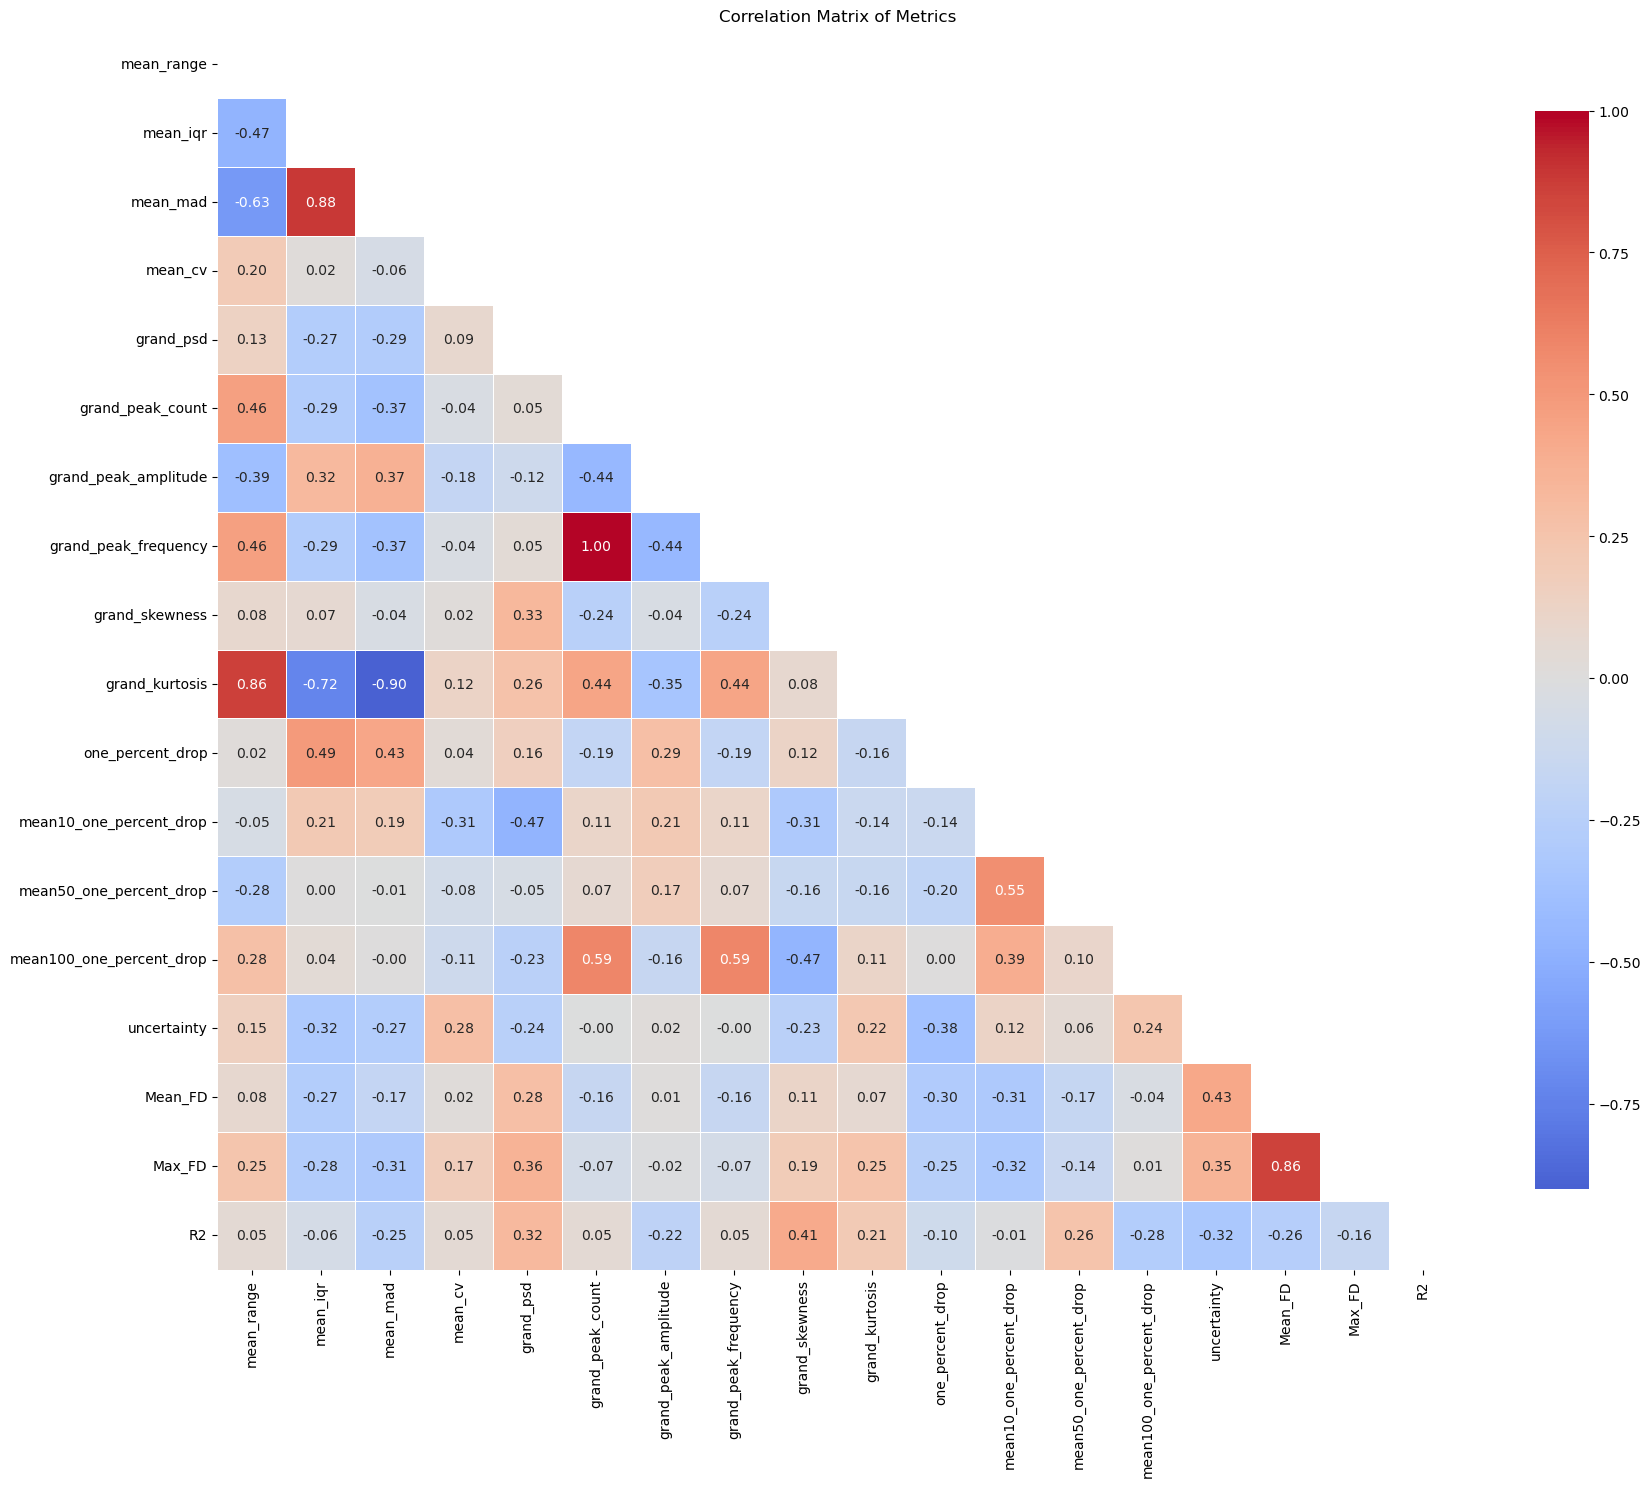

In [64]:
import pandas as pd
import seaborn as sns

# Convert dictionaries to DataFrames
df_combined = pd.DataFrame(metrics)

# Flatten MultiIndex columns
#df_combined.columns = ['_'.join(col) for col in df_combined.columns]

# Compute correlation matrix
corr_matrix = df_combined.corr()

# # Plot the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Metrics')
# plt.show()




mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Choose a custom colormap (e.g., 'coolwarm')
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Plot the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, center=0,
            square=True, fmt='.2f',linewidths=.5, cbar_kws={"shrink": 0.7})


# plt.xticks( np.arange(len(feature_names))+.5, feature_names, rotation=45)
# plt.yticks( np.arange(len(feature_names))+.5, feature_names, rotation=0)
plt.title("Correlation Matrix of Metrics")

plt.show()